<h1><strong>Program to perfom text analytics, NLP, Sentiment Analysis on the drug reviews</strong></h1>

In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import re
import logging

# Set the jupyter notebook options to display more text 
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [9]:
# Read the tsv with training data and testing data 
df_train = pd.read_table("drugsCom_raw\drugsComTrain_raw.tsv")
df_test = pd.read_table("drugsCom_raw\drugsComTest_raw.tsv")

df = pd.concat([df_train, df_test])

In [10]:
df.head(2)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null float64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [12]:
# Rename the unnamed column to ID column
df = df.rename(columns={'Unnamed: 0':'id'})

# Number of duplicates in review column 
dups = df['review'].duplicated().sum()
print("Duplicate rows in 'review' column : ", dups)

Duplicate rows in 'review' column :  86585


In [13]:
# Define a function to create a label column creating 3 bins (negative, neutral and positive) for all ratings
def get_label(rating):
    if rating <= 3:
        return -1 
    elif rating >= 7:
        return 1
    else:
        return 0

df['label'] = df['rating'].apply(lambda x: get_label(x))
df.head(2)

,id,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192,1


In [14]:
# Get the total values for each lable
df['label'].value_counts()

 1    142306
-1     46901
 0     25856
Name: label, dtype: int64

<h2><strong>Implementing NLP</strong></h2>
<h3><strong>Implementing Bag of Words embedding with Decision Trees and Random Forests</strong></h3>


In [15]:
%%time

# Perform some basic cleansing
rx_pat = r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(&quot;)|(\d\s)|(\d)|(\/)"
rx_pat_wSpace = r"(\-)|(\\)|(\s{2,})"
    
df['review'].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
df['review'].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
df['reivew'] = df.review.str.lower()

print(df.review.head(3))

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    It has no side effect I take it in combination of Bystolic Mg and Fish Oil
1    My son is halfway through his fourth week of Intuniv We became concerned when he began this last week when he started taking the highest dose he will be on For two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vaca

In [16]:
%%time

# Creating Vectors using bag of words embedding
# Each word becomes one feature (column)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# Creating a sparse matrix 
X = cv.fit_transform(df['review'])

y = df.label

Wall time: 1min 36s


In [17]:
# Check X
X

np.size(X, 0)

215063

In [18]:
# Check y
y = np.asarray(y)

np.size(y, 0)

215063

In [19]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# Create the Decision Tree classifier model 
clf = tree.DecisionTreeClassifier()

# Split the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
%%time

# Train the model
clf_model = clf.fit(X_train, y_train)

CPU times: user 9min 3s, sys: 2.68 s, total: 9min 5s
Wall time: 9min 10s


In [20]:
%%time 

# Perform predictions using the trained classifier
y_pred = clf_model.predict(X_test)

Wall time: 810 ms


In [21]:
# Test the accuracy 
from sklearn.metrics import accuracy_score

print ("Accuracy  score: ", accuracy_score(y_test, y_pred))

Accuracy  score:  0.8665752214446795


In [22]:
# Classification Report 
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=["Negative","Neutral", "Positive"]))
print(confusion_matrix(y_test, y_pred))

# tn, fp, xs, xy, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# (tn, fp, fn, tp)
print(confusion_matrix(y_test, y_pred).ravel())

# print(f"\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80      9423
     Neutral       0.74      0.70      0.72      5244
    Positive       0.91      0.92      0.91     28346

   micro avg       0.87      0.87      0.87     43013
   macro avg       0.82      0.81      0.81     43013
weighted avg       0.87      0.87      0.87     43013

[[ 7496   373  1554]
 [  485  3663  1096]
 [ 1338   893 26115]]
[ 7496   373  1554   485  3663  1096  1338   893 26115]


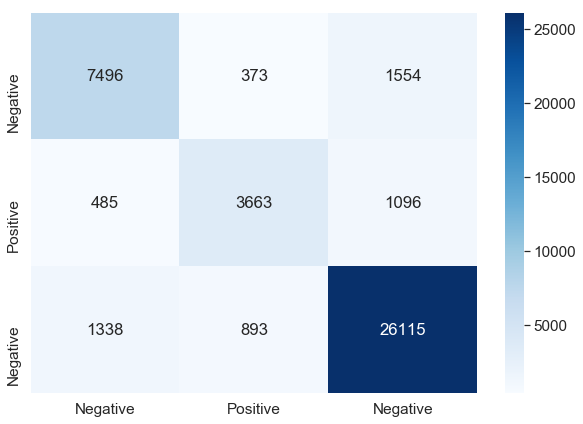

In [23]:
# Lets plot the confusion matrix 
import seaborn as sn

cm = confusion_matrix(y_test, y_pred)
# Create labels 
labels = ["Positive" if label == 0 else "Negative" for label in df.label.unique()]

sn.set(font_scale=1.4) # for font size 
df_cm = pd.DataFrame(cm, index = [i for i in labels], 
                    columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

In [29]:
%%time

# Implementing Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

## build Random forest model
random_forest = RandomForestClassifier(n_estimators=100)

## Train the classifiers
# decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)



CPU times: user 36min 51s, sys: 35.1 s, total: 37min 26s
Wall time: 39min 1s


In [24]:
# Create Predictions
rf_pred = random_forest.predict(X_test)

In [25]:
# Check the performance of the model
print('Random Forest Model')
print(classification_report(y_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive']))

#Graph our confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
print("Random Forest - Confusion Matrix:\n", rf_cm)

# False and True
# tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()
print(confusion_matrix(y_test, rf_pred).ravel())

# (tn, fp, fn, tp)

# print(f"\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

# Test the accuracy 
print ("\nAccuracy  score: ", round(accuracy_score(y_test, rf_pred), 3))

Random Forest Model
              precision    recall  f1-score   support

    Negative       0.98      0.72      0.83      9423
     Neutral       1.00      0.65      0.79      5244
    Positive       0.86      1.00      0.93     28346

   micro avg       0.89      0.89      0.89     43013
   macro avg       0.95      0.79      0.85     43013
weighted avg       0.91      0.89      0.89     43013

Random Forest - Confusion Matrix:
 [[ 6775     0  2648]
 [   69  3403  1772]
 [   68     1 28277]]
[ 6775     0  2648    69  3403  1772    68     1 28277]

Accuracy  score:  0.894


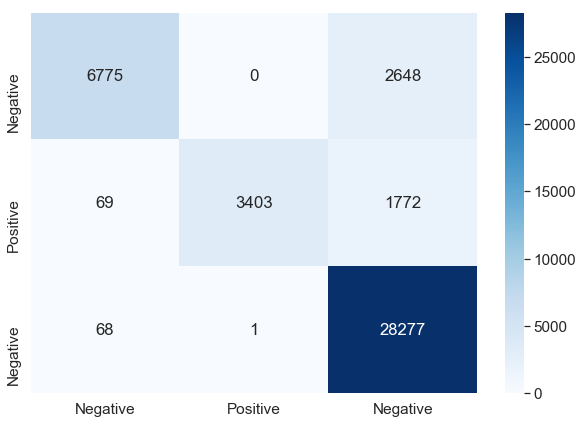

In [26]:
# Lets plot the confusion matrix 
import seaborn as sn

cm = confusion_matrix(y_test, rf_pred)
# Create labels 
labels = ["Positive" if label == 0 else "Negative" for label in df.label.unique()]

sn.set(font_scale=1.4) # for font size 
df_cm = pd.DataFrame(cm, index = [i for i in labels], 
                    columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

<h3><strong>Save the Model</strong></h3>

In [34]:
# Save the random forest model to disk
import pickle
filename = 'finalized_rf_model.sav'
pickle.dump(random_forest, open(filename, 'wb'))

In [35]:
# Save the decision tree model to disk
import pickle
filename = 'finalized_dt_model.sav'
pickle.dump(clf_model, open(filename, 'wb'))

In [7]:
# load the models from disk
clf_model = pickle.load(open('finalized_dt_model.sav', 'rb'))
random_forest = pickle.load(open('finalized_rf_model.sav', 'rb'))



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breakin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breakin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breakin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.20.1. This might lead to breakin

<h3><strong>Run the model on new reviews</strong></h3>

In [26]:
# Let's test the model 
# Define a function to create a pipeline and run the predictions
def classify(text, classifier='None'):
    # Creating a sparse matrix 
    review_matrix = cv.transform([text])
    if classifier.lower() == 'decision tree':
        # Predict the outcome 
        y_prediction = clf_model.predict(review_matrix)
    elif classifier.lower() == 'random forest':
        y_prediction = random_forest.predict(review_matrix)
    else:
        return "Wrong/No classifier selected"       
    
    # Print the outcome
    print("Positive") if y_prediction else print("Negative")
    

In [28]:
# Positive test #1
review = "I feel better."
classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)

Positive


In [ ]:
# Positive test #2
review = "I still have pain."
# classifier = "Decision Tree"
classifier = "Random Forest"
classify(review, classifier)

In [ ]:
# Negative test #1
review = "I feel sick."
classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)

In [ ]:
# Negative test #2
review = "I am very unhappy"
# classifier = "Decision Tree"
classifier = "Random Forest"
classify(review, classifier)